# LLM as a judge for Transcripts (Doctor and Patient Chatbots) - version 2.1

Some improvements to tackle:
- use 4o-mini (cheaper)
- make sure that transcript-judge works for reluctant patient. As in, if patient is holding back information without the doctor bot probing further for more information, we should penalize the score.

In [1]:
import typing
import os
import pickle
import time
import json
from pprint import pprint
import concurrent.futures

import pandas as pd
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage
from dotenv import load_dotenv

# Load API keys from .env file
load_dotenv()

# pandas settings
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 300)

In [2]:
# Create the ChatOpenAI model instance

# model_name = "gpt-3.5-turbo-0125"  # release date: 2024-01-25
# model_name = "gpt-3.5-turbo-1106"  # release date: 2023-11-06
# model_name = "gpt-4o-2024-05-13"  # release date: 2024-05-13
model_name = "gpt-4o-mini"  # release date: 2024-07-18

model = ChatOpenAI(temperature=0.0, model_name=model_name)

## System Prompt

In [3]:
# Define the system message for the evaluation

symptom_ask_description = "Did the DOCTOR ask about '{symptom}' and was successful in getting a confirmation from PATIENT on whether the PATIENT experiences it?"

judge_criteria = {
    # introduction
    "patient_name": "Was the PATIENT's name mentioned by the DOCTOR?",
    # symptoms
    "dyspnea": symptom_ask_description.format(
        symptom="dyspnea (shortness of breath) at rest, while walking or climbing stairs"
    ),
    "pnd": symptom_ask_description.format(
        symptom="paroxysmal nocturnal dyspnea (PND) (sudden shortness of breath at night)"
    ),
    "orthopnea": symptom_ask_description.format(
        symptom="orthopnea (shortness of breath while lying flat)"
    ),
    "ankle_edema": symptom_ask_description.format(
        symptom="ankle edema or general lower extremity swelling (swelling in ankles or legs)"
    ),
    "nocturnal_cough": symptom_ask_description.format(
        symptom="nocturnal cough (coughing at night)"
    ),
    "chest_pain": symptom_ask_description.format(symptom="chest pain"),
    "fatigue": symptom_ask_description.format(symptom="fatigue"),
    "worsening_mental_status": symptom_ask_description.format(
        symptom="worsening mental status that is acute (sudden confusion or mental changes)"
    ),
    # medications
    "doctor_ask_medications": "Did the DOCTOR ask the PATIENT what medications they are on?",
    # vitals
    "temperature": "Did the DOCTOR ask for the PATIENT's temperature/body temperature?",
    "heart_rate": "Did the DOCTOR ask for the PATIENT's heart rate (pulse)?",
    "respiratory_rate": "Did the DOCTOR ask for the PATIENT's respiratory rate (number of breaths per minute)?",
    "oxygen_saturation": "Did the DOCTOR ask for the PATIENT's oxygen saturation (oxygen level in the blood)?",
    "blood_pressure": "Did the DOCTOR ask for the PATIENT's blood pressure (systolic and diastolic / upper and lower blood pressure numbers)?",
    "weight": "Did the DOCTOR ask for the PATIENT's weight (body weight)?",
    # hcp_quality
    "sympathetic_patient": "Was the DOCTOR sympathetic when the PATIENT reported symptoms or pain?",
    "reminder": "Did the DOCTOR remind the PATIENT to contact their healthcare provider if they notice any significant changes or worsening of symptoms?",
    "end_conversation": "Did the DOCTOR express care and encourage the PATIENT to reach out if they need further assistance at the end of the conversation?",
    "natural_conversation": "Did the conversation flow naturally without repetition?",
    "no_premature_end": "The conversation ended properly without a premature end.",
    # patient_quality
    "plain_language": "Did the PATIENT use plain language?",
    "consistent_symptoms": "Was the PATIENT consistent about their symptoms?",
    "no_confabulations": "Did the PATIENT avoid inventing information that contradicts the prompt (confabulations)?",
    "allow_doctor_questions": "Did the PATIENT allow the DOCTOR to ask questions and not take over the direction of the conversation (offering information before it’s asked for)?",
}

system_message_summary_judge = """You are evaluating a dialogue TRANSCRIPT generated by a DOCTOR chatbot and a PATIENT LLM bot, based on a set of criteria.
Your evaluation will consist of answering specific questions about the DOCTOR/PATIENT bot with 1 (Yes) and 0 (No) responses.
The DOCTOR bot quality should not depend on the PATIENT.
The PATIENT bot quality however does depend on its own prompt (PATIENT_PROMPT).
{output_format}

CRITERIA (column name, then a description):
""" + "\n".join(
    [f"'{k}': {v}" for k, v in judge_criteria.items()]
)

output_csv_format = """Generate a CSV row with the appropriate 1 or 0 for each criteria in the order specified below."""

output_reasoning_format = """FORMAT: In separate lines, do the following:
1. first, state the criteria you're evaluating
2. second, make a brief assessment of the criteria on the TRANSCRIPT to justify your decision
3. third, state each criteria's value (1 or 0). When explaining your assessment/reasoning
Additionally, if there are issues that result in a 0, be very specific in your assessment portion and please refer to texts in the TRANSCRIPT that is the offender. If it's a 1 (yes), keep your assessment very short.
Lastly, after all criterias are evaluated, in one last new line, please provide any short additional observations or suggestions for improvement (2 sentences), but do not repeat evaluation points previously made.
For example:

patient_name,"The DOCTOR greeted the PATIENT by name; criteria passed hence the score is 1",1
dyspnea,"The DOCTOR was successful in getting a confirmation from the PATIENT that they don't have dyspnea or shortness of breath; criteria passed hence the score is 1",1
pnd,"The DOCTOR did not ask about PND in the conversation; criteria failed hence the score is 0",0
sympathetic_patient,"The DOCTOR ignored PATIENT after PATIENT writes 'I am feeling light-headed'; criteria failed hence the score is 0",0
consistent_symptoms,"The PATIENT says 'I have chest pain' but later says 'I have no chest pain'; criteria failed hence the score is 0",0
OBSERVATION:write your two-sentence observation/improvement here
"""

human_message_summary_judge = """
PATIENT_PROMPT: {patient_prompt}

TRANSCRIPT: {transcript}
"""

In [4]:
pprint(system_message_summary_judge.format(output_format=output_reasoning_format), width=120)

('You are evaluating a dialogue TRANSCRIPT generated by a DOCTOR chatbot and a PATIENT LLM bot, based on a set of '
 'criteria.\n'
 'Your evaluation will consist of answering specific questions about the DOCTOR/PATIENT bot with 1 (Yes) and 0 (No) '
 'responses.\n'
 'The DOCTOR bot quality should not depend on the PATIENT.\n'
 'The PATIENT bot quality however does depend on its own prompt (PATIENT_PROMPT).\n'
 'FORMAT: In separate lines, do the following:\n'
 "1. first, state the criteria you're evaluating\n"
 '2. second, make a brief assessment of the criteria on the TRANSCRIPT to justify your decision\n'
 "3. third, state each criteria's value (1 or 0). When explaining your assessment/reasoning\n"
 'Additionally, if there are issues that result in a 0, be very specific in your assessment portion and please refer '
 "to texts in the TRANSCRIPT that is the offender. If it's a 1 (yes), keep your assessment very short.\n"
 'Lastly, after all criterias are evaluated, in one last new line, 

## Import Transcript

In [5]:
# Specify the path to your JSON file
base_path = "../../data/transcripts/"

transcripts_files_details = {
    # comparison between 3.5, 4o, and 4o-mini
    "gpt35_cooperative_basedoc": {
        "transcript_path": "transcripts_short_gpt3.5_basepat_basedoc_2307_clean.json",
        "model": "GPT 3.5",
        "patient_type": "cooperative",
        "doctor_type": "base",
        "transcript_key": "chat_transcript",
    },
    # these are with 4o-mini
    "gpt4omini_cooperative_basedoc": {
        "transcript_path": "transcripts_short_gpt4o-m_basepat_basedoc_2307.json",
        "model": "GPT 4o-mini",
        "patient_type": "cooperative",
        "doctor_type": "base",
        "transcript_key": "chat_transcript_full",  # NOTE: this skips end-detection
    },
    "gpt4omini_cooperative_imprdoc": {
        "transcript_path": "transcripts_short_gpt4o-m_basepat_imprdoc_2607.json",
        "model": "GPT 4o-mini",
        "patient_type": "cooperative",
        "doctor_type": "improved",
        "transcript_key": "chat_transcript_full",
    },
    "gpt4omini_reluctant_basedoc": {
        "transcript_path": "transcripts_short_gpt4o-m_rel3pat_basedoc_2607.json",
        "model": "GPT 4o-mini",
        "patient_type": "reluctant",
        "doctor_type": "base",
        "transcript_key": "chat_transcript_full",
    },
    "gpt4omini_reluctant_imprdoc": {
        "transcript_path": "transcripts_short_gpt4o-m_rel3pat_imprdoc_2607.json",
        "model": "GPT 4o-mini",
        "patient_type": "reluctant",
        "doctor_type": "improved",
        "transcript_key": "chat_transcript_full",
    },
    # new 3007 transcripts that were ran with 4o
    "gpt4o_cooperative_basedoc": {
        "transcript_path": "transcripts_short_gpt4o_basepat_basedoc_2307_clean.json",
        "model": "GPT 4o",
        "patient_type": "cooperative",
        "doctor_type": "base",
        "transcript_key": "chat_transcript",
    },
    "gpt4o_cooperative_imprdoc": {
        "transcript_path": "transcripts_short_gpt4o_basepat_imprdoc_3007_clean.json",
        "model": "GPT 4o",
        "patient_type": "cooperative",
        "doctor_type": "improved",
        "transcript_key": "chat_transcript",
    },
    "gpt4o_reluctant_basedoc": {
        "transcript_path": "transcripts_short_gpt4o_rel3pat_basedoc_3007_clean.json",
        "model": "GPT 4o",
        "patient_type": "reluctant",
        "doctor_type": "base",
        "transcript_key": "chat_transcript",
    },
    "gpt4o_reluctant_imprdoc": {
        "transcript_path": "transcripts_short_gpt4o_rel3pat_imprdoc_3007_clean.json",
        "model": "GPT 4o",
        "patient_type": "reluctant",
        "doctor_type": "improved",
        "transcript_key": "chat_transcript",
    },
}

transcripts_and_details: typing.Dict[str, typing.Dict[str, typing.Any]] = {}
for transcript_name, transcript_details in transcripts_files_details.items():
    with open(base_path + transcript_details["transcript_path"], "r") as json_file:
        transcripts_and_details[transcript_name] = {"transcripts": json.load(json_file)}
        transcripts_and_details[transcript_name].update(transcripts_files_details[transcript_name])

In [6]:
# THESE ARE HELPER FUNCTIONS

def parse_response(response_content: str):
    """
    Function to validate and parse the response.

    Example response
     'intro_patient,1,""\n'
     'current_symptoms,1,""\n'
     'symptoms_agree,0,"Nose bleeding was mentioned in the summary, but not in the transcript."\n'

    Desired output
    {"intro_patient": {"value": 1, "reasoning": ""}, "current_symptoms": {"value": 1, "reasoning": ""}, ...}
    """
    response_list = response_content.split("\n")
    response_dict = {}
    for response in response_list:
        if response:
            try:
                (criteria, back_split) = response.split(",", 1)
                (reasoning, value) = back_split.rsplit(",", 1)
                response_dict[criteria] = {"value": int(value), "reasoning": reasoning.strip('"')}
            except ValueError:
                # print(f"Error parsing response: {response}")
                pass

    # additional wrangling on all: find phrase 'criteria passed hence the score is 1' and 'criteria failed hence the score is 0'
    # if found, override the value with 1 or 0
    for key, value in response_dict.items():
        if "criteria passed hence the score is 1" in value["reasoning"]:
            response_dict[key]["value"] = 1
        elif "criteria failed hence the score is 0" in value["reasoning"]:
            response_dict[key]["value"] = 0

    # find a line that starts with 'observation:' and use it as the observation
    response_dict["observations"] = ""
    for line in response_content.split("\n"):
        if line.lower().startswith("observation:"):
            response_dict["observations"] = line.split(":", 1)[1].strip()
            break

    return response_dict


def process_evaluate_transcript(
    transcript_name: str,
    patient_data: dict,
    patient_type: str,
    transcript_key: str,
    transcript_path: str,
) -> typing.Optional[dict]:
    """
    Function to evaluate a transcript based on the judge criteria.

    Args:
        transcript_name (str): Name of the transcript
        patient_data (dict): Data of the patient
        patient_type (str): Type of the patient (cooperative or reluctant)
        transcript_key (str): Key to access the transcript in the patient_data
        transcript_path (str): Path to the transcript file

    Returns:
        typing.Optional[dict]: A dictionary with the evaluation results
            containing the transcript name, patient type, id, name, filename,
            and the evaluation results for each criteria.
    """
    try:
        transcript = patient_data[transcript_key]
        patient_prompt = patient_data["prompt"]
    except KeyError as e:  # not a real patient
        return None

    prompt = (
        SystemMessage(
            content=system_message_summary_judge.format(output_format=output_reasoning_format)
        )
        + human_message_summary_judge
    )

    start_time = time.time()
    response = model.invoke(
        prompt.format_messages(transcript=transcript, patient_prompt=patient_prompt)
    )
    process_time = time.time() - start_time

    response_dict = parse_response(response.content)

    result_row = {
        "transcript_name": transcript_name,
        "patient_type": patient_type,
        "id": patient_data["id"],
        "name": patient_data["name"],
        "filename": transcript_path,
        **{k: v["value"] for k, v in response_dict.items() if k in judge_criteria.keys()},
        **{
            f"{k}_reasoning": v["reasoning"]
            for k, v in response_dict.items()
            if k in judge_criteria.keys()
        },
        "observations": response_dict["observations"],
        "response": response,
        "response_dict": response_dict,
        "process_time": process_time,
    }
    return result_row


def dot_progress(count: int, symbol: str = "."):
    print(symbol, end="")
    if (count) % 5 == 0:
        print("|", end="")


In [7]:
save_base_path = "../../data/evaluations/transcripts/2.1_llm_judge_transcript_results/"
responses_filename = "openai_api_responses.pkl"
df_filename = "df_results.pkl"

In [27]:
# EXECUTE EVALUATION FOR ALL TRANSCRIPTS 🏹

# -----loading previous results-----

# create the directory if it doesn't exist
if not os.path.exists(save_base_path):
    os.makedirs(save_base_path)

all_responses: dict = {}  # key: "{transcript_name}_{patient_id}", value: response
df_results: pd.DataFrame = pd.DataFrame()
results_list: list[dict] = []

# check to see if it's saved, if so, load it (pickle)
if os.path.exists(save_base_path + responses_filename):
    with open(save_base_path + responses_filename, "rb") as f:
        all_responses = pickle.load(f)

if os.path.exists(save_base_path + df_filename):
    df_results = pd.read_pickle(save_base_path + df_filename)
    results_list = df_results.to_dict(orient="records")

# ---order of evalutation results features---
feature_order = []
for criteria in judge_criteria.keys():
    feature_order.append(criteria)
    feature_order.append(f"{criteria}_reasoning")
feature_order.append("observations")

# ---evaluate the transcripts---
max_workers = 20  # Set the maximum number of concurrent workers

for transcript_name, transcript_data in transcripts_and_details.items():
    # patient ID keys must be numerical string; if has alphabets, skip
    real_transcripts = {k: v for k, v in transcript_data["transcripts"].items() if k.isnumeric()}

    print(f"Evaluating {transcript_name} patient transcripts ({len(real_transcripts)}): ", end="")
    transcript_key = transcript_data["transcript_key"]
    transcript_path = transcript_data["transcript_path"]
    patient_type = transcript_data["patient_type"]
    doctor_type = transcript_data["doctor_type"]
    model_name = transcript_data["model"]

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures: list[concurrent.futures.Future] = []
        count = 0
        for i, (patient_id, patient_data) in enumerate(real_transcripts.items()):
            if f"{transcript_name}_{patient_id}" in all_responses:
                count += 1
                # check for completion of data: add doctor_type and model_name
                results_list_index = next(
                    (
                        i
                        for i, result in enumerate(results_list)
                        if result["transcript_name"] == transcript_name
                        and int(result["id"]) == int(patient_id)
                    ),
                    None,
                )
                if results_list_index is not None:
                    results_list[results_list_index]["doctor_type"] = doctor_type
                    results_list[results_list_index]["model_name"] = model_name

                dot_progress(count, symbol="x")

            else:
                futures.append(
                    executor.submit(process_evaluate_transcript, transcript_name, patient_data, patient_type, transcript_key, transcript_path,)
                )

        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result:
                count += 1
                results_list.append(
                    {
                        **result,
                        "model_name": model_name,
                        "doctor_type": doctor_type,
                    }
                )
                all_responses[f"{transcript_name}_{result['id']}"] = result["response"]
                dot_progress(count)

    print("")

# ----------create dataframe----------
df_results = pd.DataFrame(results_list)

# order the columns
valid_feature_order = [col for col in feature_order if col in df_results.columns]
not_a_feature_order = [col for col in df_results.columns if col not in feature_order]
df_results = df_results[not_a_feature_order + valid_feature_order]

# --------Run time diagnostics--------
# sum up the process time
total_time = df_results["process_time"].sum()
total_evals = len(df_results)
print(f"\nEvaluated {total_evals} transcripts. Process time: {total_time:.2f} s ({total_time / total_evals:.2f} s each). IRL parallelized time: ~{total_time / max_workers:.2f} s.")

display(df_results.sample(5))

# ----------save the results----------

df_results.to_pickle(save_base_path + df_filename)
with open(save_base_path + responses_filename, "wb") as f:
    pickle.dump(all_responses, f)

Evaluating gpt35_cooperative_basedoc patient transcripts (20): xxxxx|xxxxx|xxxxx|xxxxx|
Evaluating gpt4omini_cooperative_basedoc patient transcripts (20): xxxxx|xxxxx|xxxxx|xxxxx|
Evaluating gpt4omini_cooperative_imprdoc patient transcripts (20): xxxxx|xxxxx|xxxxx|xxxxx|
Evaluating gpt4omini_reluctant_basedoc patient transcripts (20): xxxxx|xxxxx|xxxxx|xxxxx|
Evaluating gpt4omini_reluctant_imprdoc patient transcripts (20): xxxxx|xxxxx|xxxxx|xxxxx|
Evaluating gpt4o_cooperative_basedoc patient transcripts (20): xxxxx|xxxxx|xxxxx|xxxxx|
Evaluating gpt4o_cooperative_imprdoc patient transcripts (20): xxxxx|xxxxx|xxxxx|xxxxx|
Evaluating gpt4o_reluctant_basedoc patient transcripts (20): xxxxx|xxxxx|xxxxx|xxxxx|
Evaluating gpt4o_reluctant_imprdoc patient transcripts (20): xxxxx|xxxxx|xxxxx|xxxxx|

Evaluated 180 transcripts. Process time: 1741.63 s (9.68 s each). IRL parallelized time: ~87.08 s.


,transcript_name,patient_type,id,name,filename,response,response_dict,process_time,doctor_type,model_name,patient_name,patient_name_reasoning,dyspnea,dyspnea_reasoning,pnd,pnd_reasoning,orthopnea,orthopnea_reasoning,ankle_edema,ankle_edema_reasoning,nocturnal_cough,nocturnal_cough_reasoning,chest_pain,chest_pain_reasoning,fatigue,fatigue_reasoning,worsening_mental_status,worsening_mental_status_reasoning,doctor_ask_medications,doctor_ask_medications_reasoning,temperature,temperature_reasoning,heart_rate,heart_rate_reasoning,respiratory_rate,respiratory_rate_reasoning,oxygen_saturation,oxygen_saturation_reasoning,blood_pressure,blood_pressure_reasoning,weight,weight_reasoning,sympathetic_patient,sympathetic_patient_reasoning,reminder,reminder_reasoning,end_conversation,end_conversation_reasoning,natural_conversation,natural_conversation_reasoning,no_premature_end,no_premature_end_reasoning,plain_language,plain_language_reasoning,consistent_symptoms,consistent_symptoms_reasoning,no_confabulations,no_confabulations_reasoning,allow_doctor_questions,allow_doctor_questions_reasoning,observations
86,gpt4omini_reluctant_imprdoc,reluctant,13404233,Randy Freeman,transcripts_short_gpt4o-m_rel3pat_imprdoc_2607.json,"content='patient_name,""The DOCTOR greeted the PATIENT by name; criteria passed hence the score is 1"",1\ndyspnea,""The DOCTOR successfully asked about shortness of breath and received a confirmation from the PATIENT that they experience it while walking; criteria passed hence the score is 1"",1\npn...","{'patient_name': {'value': 1, 'reasoning': 'The DOCTOR greeted the PATIENT by name; criteria passed hence the score is 1'}, 'dyspnea': {'value': 1, 'reasoning': 'The DOCTOR successfully asked about shortness of breath and received a confirmation from the PATIENT that they experience it while wal...",8.714813,improved,GPT 4o-mini,1,The DOCTOR greeted the PATIENT by name; criteria passed hence the score is 1,1,The DOCTOR successfully asked about shortness of breath and received a confirmation from the PATIENT that they experience it while walking; criteria passed hence the score is 1,0,"The DOCTOR asked about PND, but the PATIENT was unsure and did not provide a confirmation; criteria failed hence the score is 0",1,The DOCTOR asked about orthopnea and received a vague response about using an extra pillow occasionally; criteria passed hence the score is 1,1,The DOCTOR asked about ankle edema and received a confirmation from the PATIENT after probing; criteria passed hence the score is 1,1,The DOCTOR asked about nocturnal cough and the PATIENT confirmed they haven't noticed any; criteria passed hence the score is 1,1,The DOCTOR asked about chest pain and the PATIENT confirmed they haven't had any; criteria passed hence the score is 1,1,The DOCTOR asked about fatigue and the PATIENT confirmed feeling a bit more tired than usual; criteria passed hence the score is 1,0,"The DOCTOR asked about changes in mental clarity, but the PATIENT was unsure; criteria failed hence the score is 0",1,The DOCTOR asked the PATIENT about their medications; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's temperature and received a specific reading; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's heart rate and received a specific reading; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's respiratory rate and received a specific reading; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's oxygen saturation and received a specific reading; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's blood pressure and received a specific reading; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's weight and received a specific reading; criteria passed hence the score is 1,1,The DOCTOR expressed sympathy when the PATIENT reported symptoms; criteria passed hence the score is 1,0,The DOCTOR did not remind the PATIENT to conta

In [8]:
# An example of a parsed response
parse_response(all_responses["gpt35_cooperative_basedoc_14206800"].content)

NameError: name 'all_responses' is not defined

In [24]:
# what's an average response resource usage?
pprint(all_responses["gpt35_cooperative_basedoc_14206800"].response_metadata, width=120)

{'finish_reason': 'stop',
 'logprobs': None,
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_9b0abffe81',
 'token_usage': {'completion_tokens': 831, 'prompt_tokens': 2562, 'total_tokens': 3393}}


In [8]:
# what's the total resource usage? For 4o-mini
prompt_cost = 0.15 / 1e6  # $0.15 per 1M tokens
completion_cost = 0.60 / 1e6  # $0.60 per 1M tokens

total_prompt_tokens = sum([r.response_metadata["token_usage"]["prompt_tokens"] for r in all_responses.values()])
total_completion_tokens = sum([r.response_metadata["token_usage"]["completion_tokens"] for r in all_responses.values()])

print(f"Total prompt tokens: {total_prompt_tokens}, cost: ${(total_prompt_cost := total_prompt_tokens * prompt_cost):0.3f}, average: {total_prompt_tokens / len(all_responses):.2f} tokens per response")
print(f"Total completion tokens: {total_completion_tokens}, cost: ${(total_completion_cost := total_completion_tokens * completion_cost):0.3f}, average: {total_completion_tokens / len(all_responses):.2f} tokens per response")
print(f"Total cost: ${total_prompt_cost + total_completion_cost:0.3f} for {len(all_responses)} responses")

Total prompt tokens: 644109, cost: $0.097, average: 3578.38 tokens per response
Total completion tokens: 152886, cost: $0.092, average: 849.37 tokens per response
Total cost: $0.188 for 180 responses


### Some stats

In [9]:
# run this if necessary
df_results = pd.read_pickle(save_base_path + df_filename)

df_mean.shape=(25, 4)
transcript_name
Cooperative Patient, Base Doctor        20
Cooperative Patient, Improved Doctor    20
Reluctant Patient, Base Doctor          20
Reluctant Patient, Improved Doctor      20
Name: patient_name, dtype: int64


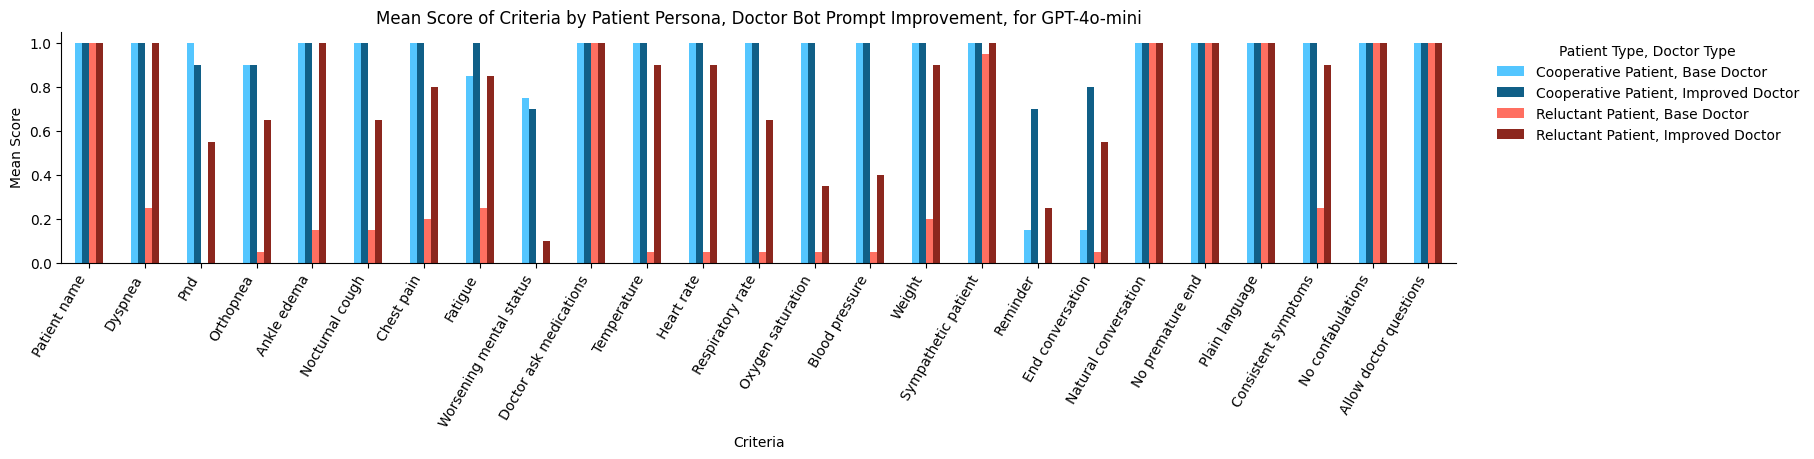

In [79]:
df = df_results.copy()

transcript_names_to_plot = ["gpt4omini_cooperative_basedoc", "gpt4omini_cooperative_imprdoc", "gpt4omini_reluctant_basedoc", "gpt4omini_reluctant_imprdoc"]
# replace colors. use light blue, dark blue, light red, dark red
colors = ["#54c6ff", "#105f87", "#ff6f61", "#8c271e"]

df = df[df["transcript_name"].isin(transcript_names_to_plot)]
df.groupby("transcript_name")[list(judge_criteria.keys())].mean()

# plot bar plot
df["transcript_name"] = pd.Categorical(df["transcript_name"], categories=transcript_names_to_plot, ordered=True)

# for legend, combine patient type and doctor type
df["transcript_name"] = df["patient_type"].str.capitalize() + " Patient, " + df["doctor_type"].str.capitalize() + " Doctor"

df_grouped = df.groupby("transcript_name")[list(judge_criteria.keys())]
df_mean = df_grouped.mean().T
df_mean.plot(kind="bar", figsize=(18, 3), color=colors)
# validation
print(f"{df_mean.shape=}")
print(df_grouped.count()["patient_name"])

plt.legend(title="Patient Type, Doctor Type", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(ticks=range(len(judge_criteria)), labels=[x.replace("_", " ").capitalize() for x in judge_criteria.keys()], rotation=60, ha="right")

plt.ylabel("Mean Score")
plt.xlabel("Criteria")
plt.title("Mean Score of Criteria by Patient Persona, Doctor Bot Prompt Improvement, for GPT-4o-mini")

plt.show()

df_mean.shape=(25, 4)
transcript_name
Cooperative Patient, Base Doctor        20
Cooperative Patient, Improved Doctor    20
Reluctant Patient, Base Doctor          20
Reluctant Patient, Improved Doctor      20
Name: patient_name, dtype: int64


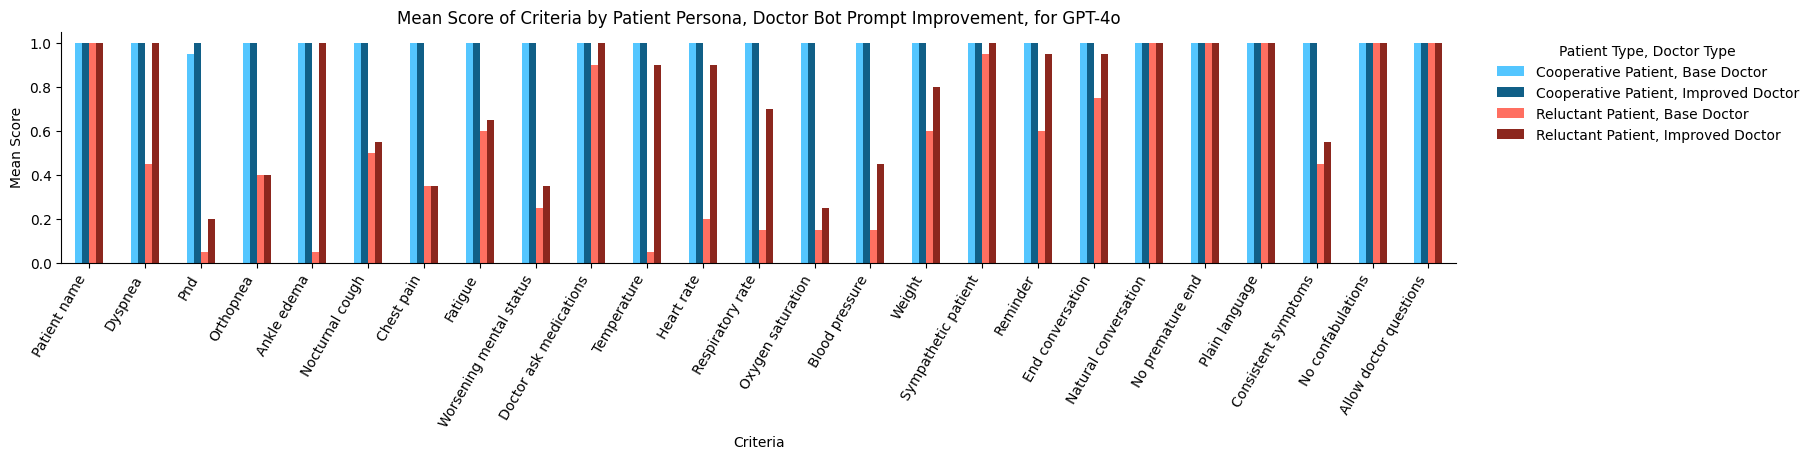

In [11]:
df = df_results.copy()

transcript_names_to_plot = ["gpt4o_cooperative_basedoc", "gpt4o_cooperative_imprdoc", "gpt4o_reluctant_basedoc", "gpt4o_reluctant_imprdoc"]
# replace colors. use light blue, dark blue, light red, dark red
colors = ["#54c6ff", "#105f87", "#ff6f61", "#8c271e"]

df = df[df["transcript_name"].isin(transcript_names_to_plot)]
df.groupby("transcript_name")[list(judge_criteria.keys())].mean()

# plot bar plot
df["transcript_name"] = pd.Categorical(
    df["transcript_name"], categories=transcript_names_to_plot, ordered=True
)

# for legend, combine patient type and doctor type
df["transcript_name"] = df["patient_type"].str.capitalize() + " Patient, " + df["doctor_type"].str.capitalize() + " Doctor"

df_grouped = df.groupby("transcript_name")[list(judge_criteria.keys())]
df_mean = df_grouped.mean().T
df_mean.plot(kind="bar", figsize=(18, 3), color=colors)
# validation
print(f"{df_mean.shape=}")
print(df_grouped.count()["patient_name"])

plt.legend(title="Patient Type, Doctor Type", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(ticks=range(len(judge_criteria)), labels=[x.replace("_", " ").capitalize() for x in judge_criteria.keys()], rotation=60, ha="right")

plt.ylabel("Mean Score")
plt.xlabel("Criteria")
plt.title("Mean Score of Criteria by Patient Persona, Doctor Bot Prompt Improvement, for GPT-4o")

plt.show()

df_mean.shape=(21, 4)
transcript_name
Cooperative Patient, Base Doctor        20
Cooperative Patient, Improved Doctor    20
Reluctant Patient, Base Doctor          20
Reluctant Patient, Improved Doctor      20
Name: patient_name, dtype: int64


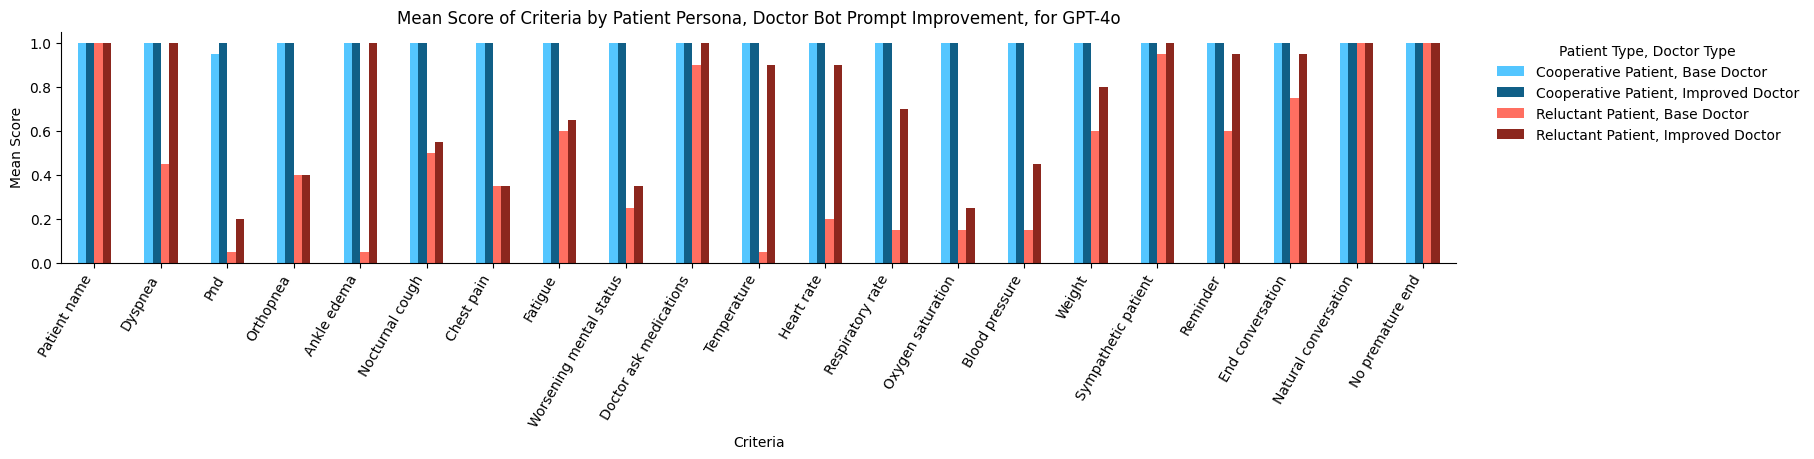

In [12]:
df = df_results.copy()

transcript_names_to_plot = ["gpt4o_cooperative_basedoc", "gpt4o_cooperative_imprdoc", "gpt4o_reluctant_basedoc", "gpt4o_reluctant_imprdoc"]
# replace colors. use light blue, dark blue, light red, dark red
colors = ["#54c6ff", "#105f87", "#ff6f61", "#8c271e"]
# columns to exclude
exclude_columns = ["plain_language", "consistent_symptoms", "no_confabulations", "allow_doctor_questions"]
leftover_judge_criteria = {k: v for k, v in judge_criteria.items() if k not in exclude_columns}

df = df[df["transcript_name"].isin(transcript_names_to_plot)].drop(columns=exclude_columns)
df.groupby("transcript_name")[list(leftover_judge_criteria.keys())].mean()

# plot bar plot
df["transcript_name"] = pd.Categorical(
    df["transcript_name"], categories=transcript_names_to_plot, ordered=True
)

# for legend, combine patient type and doctor type
df["transcript_name"] = df["patient_type"].str.capitalize() + " Patient, " + df["doctor_type"].str.capitalize() + " Doctor"

df_grouped = df.groupby("transcript_name")[list(leftover_judge_criteria.keys())]
df_mean = df_grouped.mean().T
df_mean.plot(kind="bar", figsize=(18, 3), color=colors)
# validation
print(f"{df_mean.shape=}")
print(df_grouped.count()["patient_name"])

plt.legend(title="Patient Type, Doctor Type", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(ticks=range(len(leftover_judge_criteria)), labels=[x.replace("_", " ").capitalize() for x in leftover_judge_criteria.keys()], rotation=60, ha="right")

plt.ylabel("Mean Score")
plt.xlabel("Criteria")
plt.title("Mean Score of Criteria by Patient Persona, Doctor Bot Prompt Improvement, for GPT-4o")

plt.show()

df_mean.shape=(20, 4)
plot_name
Cooperative Patient, Base Doctor        20
Cooperative Patient, Improved Doctor    20
Reluctant Patient, Base Doctor          20
Reluctant Patient, Improved Doctor      20
Name: no_premature_end, dtype: int64


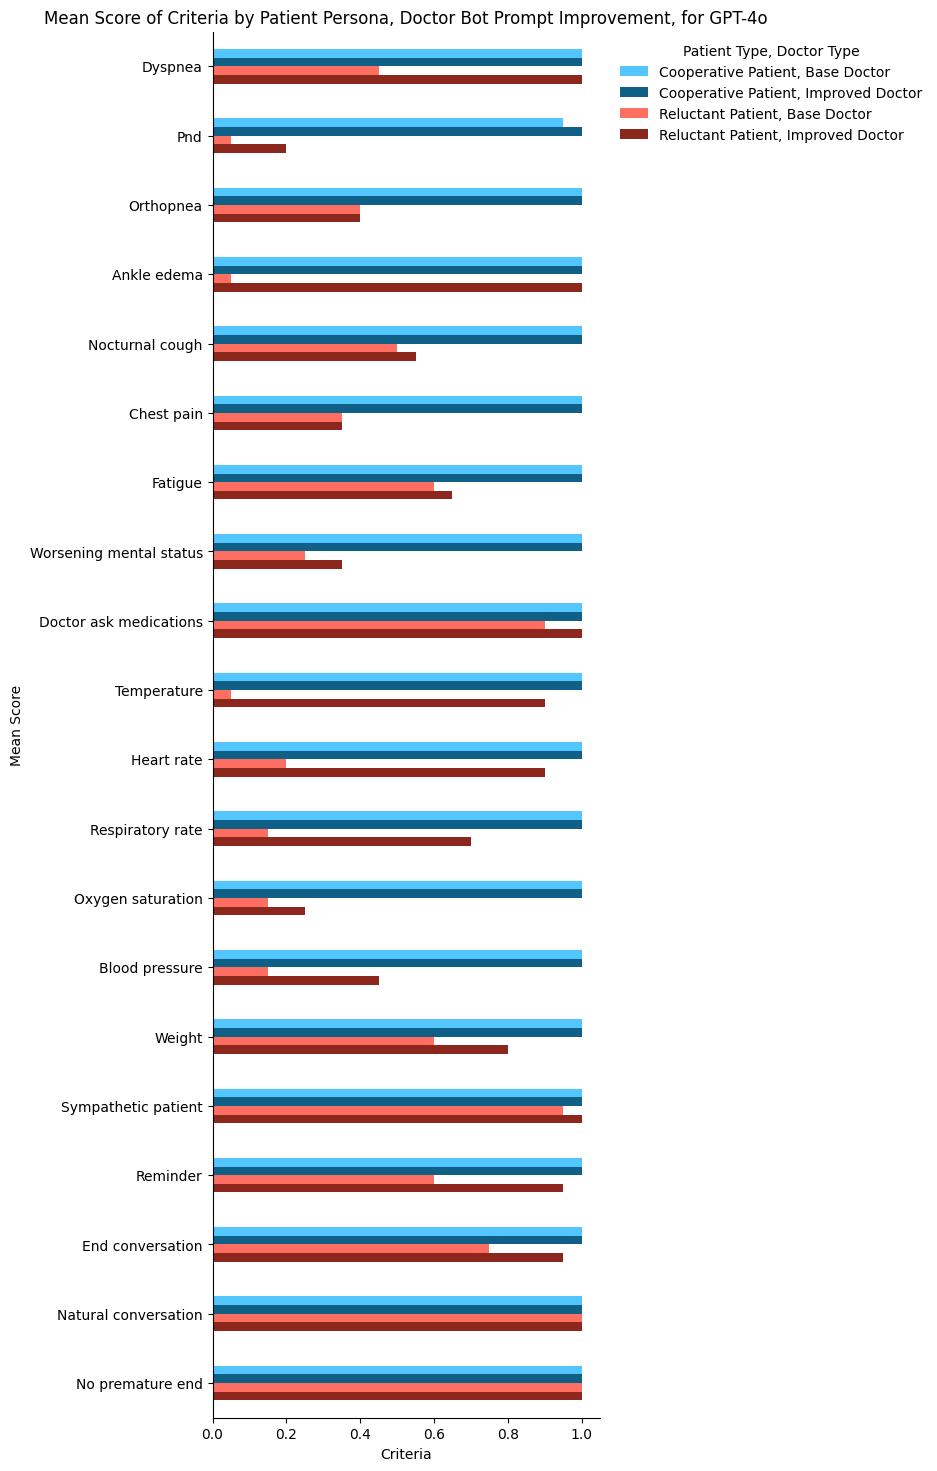

In [123]:
df = df_results.copy()

transcript_names_to_plot = list(reversed(["gpt4o_cooperative_basedoc", "gpt4o_cooperative_imprdoc", "gpt4o_reluctant_basedoc", "gpt4o_reluctant_imprdoc"]))
# replace colors. use light blue, dark blue, light red, dark red
colors = list(reversed(["#54c6ff", "#105f87", "#ff6f61", "#8c271e"]))
# columns to exclude
exclude_columns = ["plain_language", "consistent_symptoms", "no_confabulations", "allow_doctor_questions"]
leftover_judge_criteria = {k: v for k, v in judge_criteria.items() if k not in exclude_columns}

criteria_type = {
    "symptoms" : ["dyspnea", "pnd", "orthopnea", "ankle_edema", "nocturnal_cough", "chest_pain", "fatigue", "worsening_mental_status"],
    "medications" : ["doctor_ask_medications"],
    "vitals" : ["temperature", "heart_rate", "respiratory_rate", "oxygen_saturation", "blood_pressure", "weight"],
    "hcp_quality" : ["sympathetic_patient", "reminder", "end_conversation", "natural_conversation", "no_premature_end"],
}  # we're skipping all others

# reorder leftover_judge_criteria based on criteria_type
leftover_judge_criteria = dict()
for criteria_type_values in criteria_type.values():
    for criteria in criteria_type_values:
        leftover_judge_criteria[criteria] = judge_criteria[criteria]

leftover_judge_criteria_keys = list(leftover_judge_criteria.keys())

df = df[df["transcript_name"].isin(transcript_names_to_plot)]
df.groupby("transcript_name")[leftover_judge_criteria_keys].mean()

# plot bar plot
df["transcript_name"] = pd.Categorical(df["transcript_name"], categories=transcript_names_to_plot, ordered=True)

# for legend, combine patient type and doctor type
df["plot_name"] = df["patient_type"].str.capitalize() + " Patient, " + df["doctor_type"].str.capitalize() + " Doctor"
# map transcript names to combined names, based on what's in df currently
transcript_name_to_plot_name_map = {x: df[df["transcript_name"] == x]["plot_name"].iloc[0] for x in transcript_names_to_plot}

criteria_order = list(reversed(leftover_judge_criteria_keys))
df_grouped = df.groupby("plot_name")[criteria_order]
df_mean = df_grouped.mean().T[[transcript_name_to_plot_name_map[x] for x in transcript_names_to_plot]]
df_mean.plot(kind="barh", figsize=(5, 18), color=colors)
# validation
print(f"{df_mean.shape=}")
print(df_grouped.count()[criteria_order[0]])

plt.legend(title="Patient Type, Doctor Type", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
# reverse legend order
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(reversed(handles), reversed(labels), title="Patient Type, Doctor Type", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.yticks(ticks=range(len(leftover_judge_criteria)), labels=[x.replace("_", " ").capitalize() for x in criteria_order], ha="right")

plt.ylabel("Mean Score")
plt.xlabel("Criteria")
plt.title("Mean Score of Criteria by Patient Persona, Doctor Bot Prompt Improvement, for GPT-4o")

plt.show()

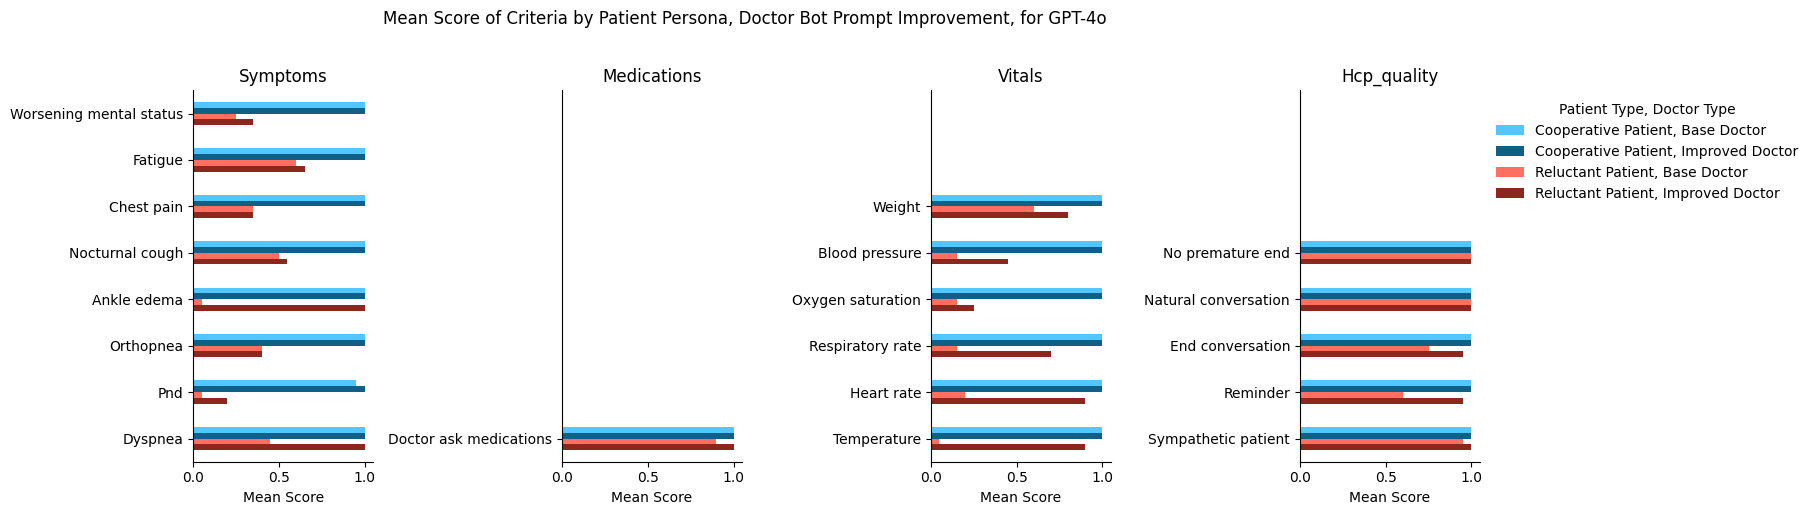

In [142]:
# Step 1: Filter and group data
df = df_results.copy()
transcript_names_to_plot = list(reversed(["gpt4o_cooperative_basedoc", "gpt4o_cooperative_imprdoc", "gpt4o_reluctant_basedoc", "gpt4o_reluctant_imprdoc"]))
colors = list(reversed(["#54c6ff", "#105f87", "#ff6f61", "#8c271e"]))
exclude_columns = ["plain_language", "consistent_symptoms", "no_confabulations", "allow_doctor_questions"]
leftover_judge_criteria = {k: v for k, v in judge_criteria.items() if k not in exclude_columns}

criteria_type = {
    "symptoms": ["dyspnea", "pnd", "orthopnea", "ankle_edema", "nocturnal_cough", "chest_pain", "fatigue", "worsening_mental_status"],
    "medications": ["doctor_ask_medications"],
    "vitals": ["temperature", "heart_rate", "respiratory_rate", "oxygen_saturation", "blood_pressure", "weight"],
    "hcp_quality": ["sympathetic_patient", "reminder", "end_conversation", "natural_conversation", "no_premature_end"],
}  # we're skipping all others

# Reorder leftover_judge_criteria based on criteria_type
leftover_judge_criteria = dict()
for criteria_type_values in criteria_type.values():
    for criteria in criteria_type_values:
        leftover_judge_criteria[criteria] = judge_criteria[criteria]

leftover_judge_criteria_keys = list(leftover_judge_criteria.keys())

df = df[df["transcript_name"].isin(transcript_names_to_plot)]

# Combine patient type and doctor type for legend
df["plot_name"] = df["patient_type"].str.capitalize() + " Patient, " + df["doctor_type"].str.capitalize() + " Doctor"
transcript_name_to_plot_name_map = {x: df[df["transcript_name"] == x]["plot_name"].iloc[0] for x in transcript_names_to_plot}

criteria_order = list(reversed(leftover_judge_criteria_keys))
df_grouped = df.groupby("plot_name")[criteria_order]
df_mean = df_grouped.mean().T[[transcript_name_to_plot_name_map[x] for x in transcript_names_to_plot]]

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharey=False)

max_criteria_n = max([len(criteria_keys) for criteria_keys in criteria_type.values()])
for i, (criteria_group, criteria_keys) in enumerate(criteria_type.items()):
    df_mean_subset = df_mean.loc[criteria_keys]
    df_mean_subset.plot(kind="barh", ax=axs[i], color=colors, legend=(i == 3))

    axs[i].set_title(criteria_group.capitalize())
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    if i != 3:
        axs[i].legend().set_visible(False)

    axs[i].set_yticks(range(len(criteria_keys)))
    axs[i].set_yticklabels([x.replace("_", " ").capitalize() for x in criteria_keys], ha="right")

    axs[i].set_xlabel("Mean Score")
    axs[i].set_ylim(-0.5, max_criteria_n - 0.5)

plt.xlabel("Mean Score")

fig.suptitle("Mean Score of Criteria by Patient Persona, Doctor Bot Prompt Improvement, for GPT-4o", y=1.02)
fig.tight_layout()

# Customizing legend for the last subplot
handles, labels = axs[3].get_legend_handles_labels()
axs[3].legend(reversed(handles), reversed(labels), title="Patient Type, Doctor Type", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.show()


In [120]:
# What's going on with some of these criteria for reluctant patients?
df = df_results.copy()
df_reluctant = df[df["transcript_name"].str.contains("gpt4o_reluctant_imprdoc")]
for criteria_to_critique in ["pnd", "orthopnea", "oxygen_saturation"]:
    bad_subset = df_reluctant[df_reluctant[criteria_to_critique] == 0][["patient_type", "doctor_type", "model_name", "id", criteria_to_critique + "_reasoning"]]
    if len(bad_subset) == 0:
        continue
    print(f"Criteria: {criteria_to_critique}, bad count: {len(bad_subset)}")
    display(bad_subset.sample(min(5, len(bad_subset))).sort_index())

Criteria: pnd, bad count: 16


,patient_type,doctor_type,model_name,id,pnd_reasoning
163,reluctant,improved,GPT 4o,12729806,The DOCTOR did not ask about PND; criteria failed hence the score is 0
167,reluctant,improved,GPT 4o,15690056,The DOCTOR asked about PND but did not receive a clear confirmation from the PATIENT; criteria failed hence the score is 0
174,reluctant,improved,GPT 4o,16526738,The DOCTOR did not ask about PND; criteria failed hence the score is 0
175,reluctant,improved,GPT 4o,15439322,"The DOCTOR asked about PND, but the PATIENT was vague and did not provide a clear confirmation; criteria failed hence the score is 0"
176,reluctant,improved,GPT 4o,17522005,The DOCTOR asked about PND but did not get a clear confirmation from the PATIENT; criteria failed hence the score is 0


Criteria: orthopnea, bad count: 12


,patient_type,doctor_type,model_name,id,orthopnea_reasoning
161,reluctant,improved,GPT 4o,16183439,"The DOCTOR asked about orthopnea and received a vague response from the PATIENT, but did not get a clear confirmation; criteria failed hence the score is 0"
164,reluctant,improved,GPT 4o,10406570,The DOCTOR did not ask about orthopnea; criteria failed hence the score is 0
172,reluctant,improved,GPT 4o,17848200,The DOCTOR asked about orthopnea but did not receive a clear confirmation from the PATIENT; criteria failed hence the score is 0
175,reluctant,improved,GPT 4o,15439322,The DOCTOR did not ask about orthopnea; criteria failed hence the score is 0
177,reluctant,improved,GPT 4o,11933271,The DOCTOR did not ask about orthopnea; criteria failed hence the score is 0


Criteria: oxygen_saturation, bad count: 15


,patient_type,doctor_type,model_name,id,oxygen_saturation_reasoning
165,reluctant,improved,GPT 4o,18025681,"The DOCTOR asked for the PATIENT's oxygen saturation, but the PATIENT did not provide a reading; criteria failed hence the score is 0"
166,reluctant,improved,GPT 4o,13690559,The DOCTOR asked for the PATIENT's oxygen saturation but did not receive a response; criteria failed hence the score is 0
170,reluctant,improved,GPT 4o,11242742,The DOCTOR asked for the PATIENT's oxygen saturation but the PATIENT did not provide a reading; criteria failed hence the score is 0
171,reluctant,improved,GPT 4o,14631874,The DOCTOR asked for the PATIENT's oxygen saturation but did not receive a clear answer; criteria failed hence the score is 0
174,reluctant,improved,GPT 4o,16526738,"The DOCTOR asked for the PATIENT's oxygen saturation, but the PATIENT did not understand the question and did not provide a reading; criteria failed hence the score is 0"


df_mean.shape=(21, 3)
model_name
GPT 3.5        20
GPT 4o         20
GPT 4o-mini    20
Name: patient_name, dtype: int64


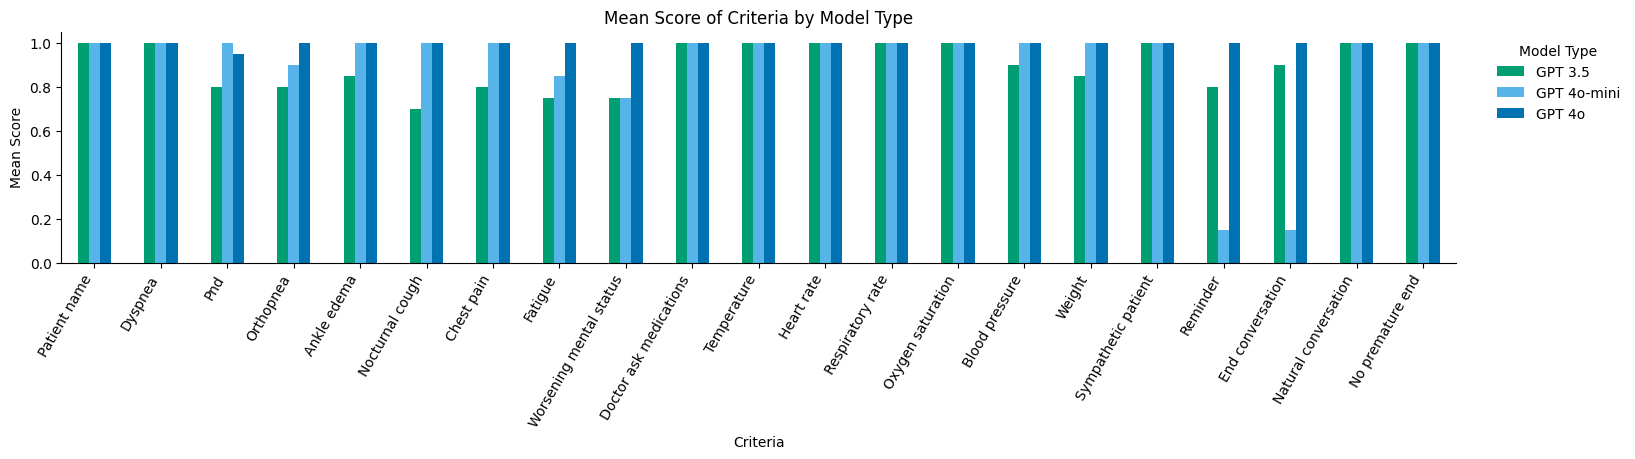

df_average_over_patients.shape=(3, 22)


model_name,GPT 3.5,GPT 4o-mini,GPT 4o
criteria_type,,,
symptoms,0.806250,0.9375,0.99375
medications,1.000000,1.0000,1.00000
vitals,0.958333,1.0000,1.00000
hcp_quality,0.940000,0.6600,1.00000


(0.0, 1.05)

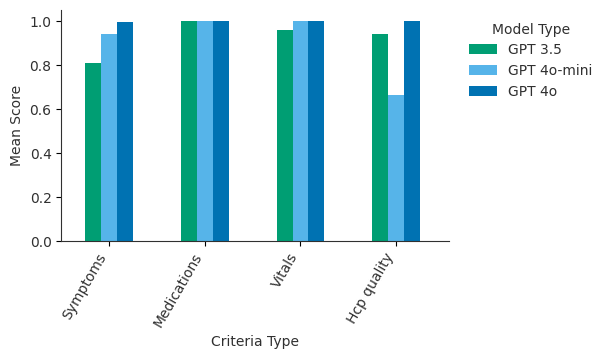

In [259]:
df = df_results.copy()

transcript_names_to_plot = ["gpt35_cooperative_basedoc","gpt4omini_cooperative_basedoc", "gpt4o_cooperative_basedoc"]
colors = ["#009E73", "#56B4E9", "#0072B2"]
# columns to exclude
exclude_columns = ["plain_language", "consistent_symptoms", "no_confabulations", "allow_doctor_questions"]
leftover_judge_criteria = {k: v for k, v in judge_criteria.items() if k not in exclude_columns}
transcript_name_to_model_name = df.groupby("transcript_name", observed=False)["model_name"].first().to_dict()

df = df[df["transcript_name"].isin(transcript_names_to_plot)].drop(columns=exclude_columns)

# plot bar plot
df["transcript_name"] = pd.Categorical(df["transcript_name"], categories=transcript_names_to_plot)

# for legend, combine patient type and doctor type
# get order based off of transcript_names_to_plot
model_name_order = [transcript_name_to_model_name[x] for x in transcript_names_to_plot]

df_grouped = df.groupby("model_name")[list(leftover_judge_criteria.keys())]
df_mean = df_grouped.mean().T[model_name_order]
df_mean.plot(kind="bar", figsize=(18, 3), color=colors)
# validation
print(f"{df_mean.shape=}")
print(df_grouped.count()["patient_name"])

plt.legend(title="Model Type", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(ticks=range(len(leftover_judge_criteria)), labels=[x.replace("_", " ").capitalize() for x in leftover_judge_criteria.keys()], rotation=60, ha="right")

plt.ylabel("Mean Score")
plt.xlabel("Criteria")
plt.title("Mean Score of Criteria by Model Type")

plt.show()

# then another plot where criteria is aggregated by question/crieria type
criteria_type = {
    "symptoms" : ["dyspnea", "pnd", "orthopnea", "ankle_edema", "nocturnal_cough", "chest_pain", "fatigue", "worsening_mental_status"],
    "medications" : ["doctor_ask_medications"],
    "vitals" : ["temperature", "heart_rate", "respiratory_rate", "oxygen_saturation", "blood_pressure", "weight"],
    "hcp_quality" : ["sympathetic_patient", "reminder", "end_conversation", "natural_conversation", "no_premature_end"],
}  # we're skipping all others

df_average_over_patients = df_mean.T.copy()
df_average_over_patients["model_name"] = df_average_over_patients.index

# validation
print(f"{df_average_over_patients.shape=}")

df_average_over_patients_melt = df_average_over_patients.melt(id_vars="model_name", var_name="criteria", value_name="mean_score")
df_average_over_patients_melt["criteria_type"] = df_average_over_patients_melt["criteria"].apply(lambda x: next((k for k, v in criteria_type.items() if x in v), None))
df_average_over_patients_melt = df_average_over_patients_melt.dropna(subset=["criteria_type"])
df_average_over_criteria_type = df_average_over_patients_melt.groupby(["model_name", "criteria_type"])["mean_score"].mean().unstack().T[model_name_order]

criteria_type_order = list(criteria_type.keys())
df_average_over_criteria_type = df_average_over_criteria_type.reindex(criteria_type_order)
display(df_average_over_criteria_type)  # validation

# plot bar plot
df_average_over_criteria_type.plot(kind="bar", figsize=(5, 3), color=colors)

# styling
# set default color for x-axis labels, y-axis labels, ticks, and spines
default_color = "#303030"
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_color(default_color)
plt.gca().spines['bottom'].set_color(default_color)
plt.gca().spines['left'].set_color(default_color)

plt.legend(title="Model Type", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.setp(plt.gca().get_legend().get_title(), color=default_color)
plt.setp(plt.gca().get_legend().get_texts(), color=default_color)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel("Mean Score", color=default_color)
plt.xlabel("Criteria Type", color=default_color)
# plt.title("Mean Score of Criteria by Model Type and Criteria Type")
# capitialize the xticks
plt.xticks(ticks=range(len(criteria_type)), labels=[x.replace("_", " ").capitalize() for x in criteria_type_order], rotation=60, ha="right")
plt.xlim(-0.5, len(criteria_type) - 0.45)
plt.ylim(0, 1.05)

# # draw a box around HCP quality
# hcp_quality_index = criteria_type_order.index("hcp_quality")
# plt.gca().add_patch(plt.Rectangle((hcp_quality_index - 0.5, -0.05), 1, 1.1, fill=None, edgecolor="#ff9c51", lw=2))


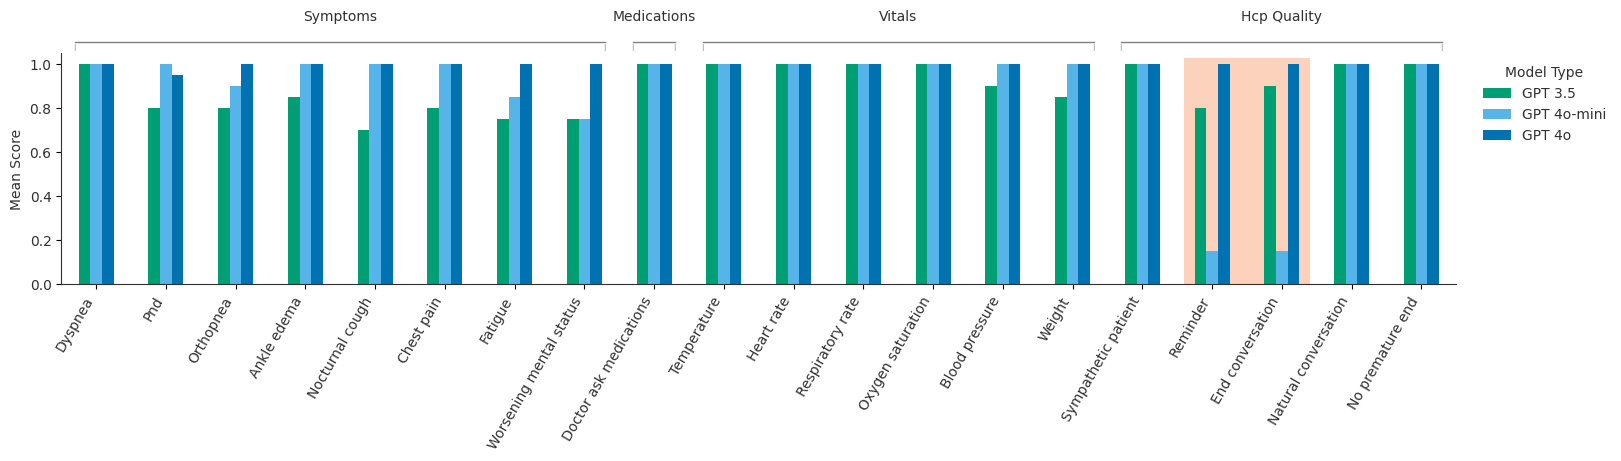

In [261]:
# Step 1: Filter and exclude specific columns
df = df_results.copy()
transcript_names_to_plot = ["gpt35_cooperative_basedoc", "gpt4omini_cooperative_basedoc", "gpt4o_cooperative_basedoc"]
colors = ["#009E73", "#56B4E9", "#0072B2"]
exclude_columns = ["plain_language", "consistent_symptoms", "no_confabulations", "allow_doctor_questions", "patient_name"]
leftover_judge_criteria = {k: v for k, v in judge_criteria.items() if k not in exclude_columns}
transcript_name_to_model_name = df.groupby("transcript_name", observed=False)["model_name"].first().to_dict()
model_name_order = [transcript_name_to_model_name[x] for x in transcript_names_to_plot]

criteria_type = {
    "symptoms": ["dyspnea", "pnd", "orthopnea", "ankle_edema", "nocturnal_cough", "chest_pain", "fatigue", "worsening_mental_status"],
    "medications": ["doctor_ask_medications"],
    "vitals": ["temperature", "heart_rate", "respiratory_rate", "oxygen_saturation", "blood_pressure", "weight"],
    "hcp_quality": ["sympathetic_patient", "reminder", "end_conversation", "natural_conversation", "no_premature_end"],
}

# Flatten the list of criteria
criteria_flat = [item for sublist in criteria_type.values() for item in sublist]
criteria_labels = [key for key, sublist in criteria_type.items() for item in sublist]

df = df[df["transcript_name"].isin(transcript_names_to_plot)].drop(columns=exclude_columns)

# Step 2: Group and calculate mean scores
df_grouped = df.groupby("model_name")[list(leftover_judge_criteria.keys())]
df_mean = df_grouped.mean().T[model_name_order]

# Plotting mean scores
fig, ax = plt.subplots(figsize=(18, 3))
df_mean.plot(kind="bar", ax=ax, color=colors)

default_color = "#303030"
ax.set_xticks(range(len(criteria_flat)))
ax.set_xticklabels([x.replace("_", " ").capitalize() for x in criteria_flat], rotation=60, ha="right")

# set default color for x-axis labels, y-axis labels, ticks, and spines
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_color(default_color)
for spine in ax.spines.values():
    spine.set_edgecolor(default_color)

ax.set_ylim(0, 1.05)

# Add criteria group labels
for i, (group, items) in enumerate(criteria_type.items()):
    start_index = criteria_flat.index(items[0])
    end_index = criteria_flat.index(items[-1])
    group_name_formatted = " ".join([x.capitalize() for x in group.split("_")])
    ax.annotate(group_name_formatted, xy=((start_index + end_index) / 40 + 0.025, 1.16), xycoords='axes fraction', ha='center', va='center', fontsize=10, color=default_color, annotation_clip=False)

    # draw a line from the start to the end
    line_height = 1.1
    extra_margin = 0.3
    ax.plot([start_index - extra_margin, end_index + extra_margin], [line_height, line_height], color='gray', lw=1, clip_on=False)

    # add small brackets at the start and end
    for x in [start_index - extra_margin, end_index + extra_margin]:
        ax.annotate("|", xy=(x - 0.01, line_height - 0.02), xycoords='data', ha='center', va='center', fontsize=5, color='gray', annotation_clip=False)

plt.legend(title="Model Type", bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)
plt.setp(ax.get_legend().get_texts(), color=default_color)
plt.setp(ax.get_legend().get_title(), color=default_color)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel("Mean Score", color=default_color)
# plt.xlabel("Criteria")
# plt.title("Mean Score of Criteria by Model Type")

# focus: put a box around "Reminder" and "End Conversation" bars
reminder_index = criteria_flat.index("reminder")
ax.add_patch(plt.Rectangle((reminder_index - 0.4, 0), 1 + 0.8, 1.03, fill=True, color="#fcd2bd", lw=0, zorder=-1))

# hcp_start_index = criteria_flat.index("sympathetic_patient")
# ax.add_patch(plt.Rectangle((hcp_start_index - 0.4, 0), 4 + 0.8, 1.03, fill=False, color="#ff9c51", lw=2, zorder=-1))


plt.show()
